# Fine-tuning Demo: Adapting a Pre-trained Model for CIFAR-10

In our previous session (or just now!), we successfully trained a Convolutional Neural Network (CNN) from scratch to classify handwritten digits from the MNIST dataset. MNIST is a great starting point, but its images are grayscale and relatively simple.

What happens when we face a more complex image classification task, perhaps with color images and more varied object classes? And what if we don't have a massive dataset or the computational resources to train a very deep network from scratch for days?

This is where **Transfer Learning** comes in. The core idea is to take a model that has already been trained on a large, general dataset (like ImageNet, which has millions of images and 1000 categories) and adapt it for our specific, often smaller, task. The intuition is that the features learned on the large dataset (like edges, textures, corners, basic shapes) are likely useful for many other visual tasks.

**Fine-tuning** is the most common way to perform transfer learning with neural networks. We will:
1. Load a pre-trained model.
2. Modify its final layer(s) to match the number of classes in our new task.
3. Continue training the model (either just the new layers or the whole model) on our new dataset.

Today, we'll do a quick demonstration using the **CIFAR-10** dataset and a lightweight pre-trained model called **MobileNetV3-Small**.

## 1. Motivation for Fine-tuning

*   **Leverages Existing Knowledge:** Why start from random weights when we can use weights trained on millions of images? Pre-trained models already understand basic visual concepts.
*   **Faster Training:** Since the initial layers already capture good features, the model often converges much faster on the new task compared to training from scratch.
*   **Better Performance (especially with limited data):** For smaller datasets, training a deep network from scratch can lead to overfitting. Using a pre-trained model provides a strong regularization effect and often leads to higher accuracy.
*   **Reduced Computational Cost:** Reaching a good performance level usually requires fewer training epochs and less overall computation.

Let's see this in action!

## 2. Loading CIFAR-10 and Defining Transformations

First, we need to load the CIFAR-10 dataset. It contains 60,000 32x32 color images in 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). We'll use `torchvision.datasets`.

A crucial step when using pre-trained models is **data transformation**. Most models pre-trained on ImageNet expect input images of a specific size (e.g., 224x224 pixels) and normalized using specific mean and standard deviation values calculated from the ImageNet dataset. We *must* apply these same transformations to our CIFAR-10 images.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision.models as models # Import models here

# Define the transformations
# We need to resize CIFAR-10's 32x32 images to 224x224
# And use the standard ImageNet normalization constants

# Use the normalization constants provided by the specific weights API
# Ensure torchvision.models is imported first
weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

print("Preprocessing steps for MobileNetV3-Small:")
print(preprocess)

# Load the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=preprocess) # Apply the transformations!

trainloader = data.DataLoader(trainset,
                              batch_size=64, # Adjust batch size based on memory
                              shuffle=True,
                              num_workers=2) # Use background workers to load data

# Load the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=preprocess) # Apply the same transformations!

testloader = data.DataLoader(testset,
                             batch_size=128, # Larger batch size for testing is often fine
                             shuffle=False,
                             num_workers=2)

# Define class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Preprocessing steps for MobileNetV3-Small:
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


100%|██████████| 170M/170M [00:21<00:00, 7.83MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Sample images from CIFAR-10 after preprocessing (may look unusual due to normalization):


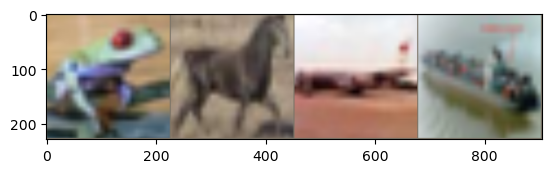

Labels: frog  horse plane ship 


In [2]:
# Optional: Code to show images (can be uncommented if needed)
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    # Note: Reversing ImageNet normalization for display is tricky.
    # It's easier to display images *before* applying the `preprocess` transform.
    # This requires loading the dataset again without the transform, just for visualization.
    # Or, manually invert the normalization:
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean # Unnormalize
    img = torch.clamp(img, 0, 1) # Clamp values to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images (requires iterating through loader)
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
print("Sample images from CIFAR-10 after preprocessing (may look unusual due to normalization):")
imshow(torchvision.utils.make_grid(images[:4].cpu())) # Move to CPU for numpy/matplotlib
# Print labels
print('Labels: ' + ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## 3. Loading the Pre-trained Model

Now, let's load MobileNetV3-Small, pre-trained on ImageNet, using `torchvision.models`. We will use the newer `weights` API, which is recommended as it bundles preprocessing information and provides better versioning.

In [3]:
import torchvision.models as models

# Load the pre-trained MobileNetV3-Small model using the recommended weights API
# We already defined 'weights' in the data loading cell, but redefining is fine:
weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
model = models.mobilenet_v3_small(weights=weights)

# Alternatively, using the older `pretrained=True` argument:
# model = models.mobilenet_v3_small(pretrained=True)

# Let's look at the model structure, especially the final classifier layer
print("Original MobileNetV3-Small structure:")
print(model)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /Users/arvindsuresh/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 11.1MB/s]

Original MobileNetV3-Small structure:
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0

Notice the last layer in the `classifier` block. For MobileNetV3-Small, it's typically something like `(3): Linear(in_features=1024, out_features=1000, bias=True)`. This layer outputs 1000 values, corresponding to the 1000 classes in ImageNet. This is not what we need for CIFAR-10, which has only 10 classes.

## 4. Adapting the Model Head

We need to replace the final layer (the "head") of the network with a new linear layer that has the correct number of output units (10 for CIFAR-10).

In [4]:
import torch.nn as nn

# Get the number of input features for the classifier's last layer
# For MobileNetV3-Small, the classifier is a Sequential module.
# The layer we want to replace is the last one.
num_ftrs = model.classifier[3].in_features

# Create a new final layer with 10 outputs (for CIFAR-10 classes)
model.classifier[3] = nn.Linear(num_ftrs, len(classes))

# Let's verify the change
print("\nModel structure after modifying the head:")
print(model.classifier) # Just show the classifier part


Model structure after modifying the head:
Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=10, bias=True)
)


Now the model structure is correct for our task. The new `nn.Linear` layer has randomly initialized weights. The rest of the model retains its pre-trained weights from ImageNet.

### Evaluating Baseline Performance (Before Fine-tuning)

Before we train the new head, let's see how the model performs "out of the box" with the frozen ImageNet features and the randomly initialized classification layer. We expect the accuracy to be quite low (around 10% for 10 classes, i.e., random guessing).

In [5]:
import torch

# Set up device (MPS for M2 Mac, fallback to CPU)
# Check if MPS is available and PyTorch version is compatible
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Fallback to CUDA then CPU

print(f"Using device: {device}")
model.to(device) # Move the model to the chosen device

# Evaluation function
@torch.no_grad() # Decorator for efficiency, equivalent to 'with torch.no_grad():'
def evaluate(model, dataloader, device):
    model.eval() # Set model to evaluation mode
    correct = 0
    total = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    model.train() # Set model back to train mode just in case
    return accuracy

# Evaluate on the test set *before* training the head
print("Evaluating baseline performance (random head)...")
baseline_accuracy = evaluate(model, testloader, device)
print(f'Accuracy on the test set before fine-tuning: {baseline_accuracy:.2f} %')

Using device: mps
Evaluating baseline performance (random head)...
Accuracy on the test set before fine-tuning: 15.00 %


As expected, the accuracy is very low because the final layer hasn't been trained yet.

## 5. Fine-tuning Strategy: Feature Extraction

For this demonstration, we'll use the **Feature Extraction** strategy. This means we will **freeze** the weights of all layers *except* the final classifier layer we just added. We will only train the weights of this new layer. This is computationally efficient and often works well when the new dataset is similar to the original pre-training dataset or when the new dataset is small.

In [6]:
# Freeze all the parameters in the convolutional base
print("Freezing base model parameters...")
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the final layer we added
# Note: We need to ensure only the parameters of the *new* layer are trainable.
# For MobileNetV3-Small, we replaced model.classifier[3]
print("Unfreezing parameters of the final classifier layer...")
for param in model.classifier[3].parameters():
    param.requires_grad = True

# Optional: Verify which parameters require gradients
print("\nParameters requiring gradients:")
total_params = 0
trainable_params = 0
for name, param in model.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        print(name)
        trainable_params += param.numel()

print(f"\nTotal parameters: {total_params}")
print(f"Trainable parameters: {trainable_params} ({(100.0 * trainable_params / total_params):.2f}% of total)")

Freezing base model parameters...
Unfreezing parameters of the final classifier layer...

Parameters requiring gradients:
classifier.3.weight
classifier.3.bias

Total parameters: 1528106
Trainable parameters: 10250 (0.67% of total)


You should see that only the `weight` and `bias` of `classifier.3` require gradients, representing a tiny fraction of the total parameters.

## 6. Setting up Training Components

We need a loss function and an optimizer, just like when training from scratch. However, we must tell the optimizer to *only* update the parameters that we unfroze (i.e., those where `requires_grad = True`).

In [7]:
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
# We pass *only* the parameters that should be updated (those of the new head)
# This ensures the frozen layers are not touched by the optimizer.

# Method 1: Filter parameters explicitly
params_to_update = filter(lambda p: p.requires_grad, model.parameters())
print("\nCreating optimizer for trainable parameters...")

# Method 2: Collect parameters in a list (as done before)
# params_to_update = []
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         params_to_update.append(param)


# Use Adam, a common optimizer for fine-tuning
optimizer = optim.Adam(params_to_update, lr=0.001)

# Alternatively, AdamW is often preferred for transformers, and good here too
# optimizer = optim.AdamW(params_to_update, lr=0.001)

print("Optimizer created.")


Creating optimizer for trainable parameters...
Optimizer created.


## 7. Running the Training Loop

Now we run the training loop. It looks very similar to the MNIST loop, but the model and data are different, and crucially, only the final layer's weights are being updated. We will train for just 1 or 2 epochs for this demo to show how quickly performance can improve.

In [8]:
import time # To time the training

# Number of epochs for the demo
num_epochs = 2 # Keep this low for a quick demo

print(f"\nStarting training for {num_epochs} epochs...")

model.train() # Set the model to training mode

start_time = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0
    epoch_start_time = time.time()

    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # Move data to device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass (only computes gradients for the unfrozen layer)
        loss.backward()

        # Optimize (only updates weights of the unfrozen layer)
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99: # Print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch + 1} finished in {epoch_duration:.2f} seconds.")

total_training_time = time.time() - start_time
print(f'Finished Training in {total_training_time:.2f} seconds.')

# Evaluate the model *after* fine-tuning the head
print("\nEvaluating performance after fine-tuning...")
final_accuracy = evaluate(model, testloader, device)
print(f'Accuracy on the test set after fine-tuning: {final_accuracy:.2f} %')

# Compare with baseline
print(f'\nBaseline accuracy (random head): {baseline_accuracy:.2f} %')
print(f'Accuracy after {num_epochs} epochs of tuning the head: {final_accuracy:.2f} %')


Starting training for 2 epochs...
[1,   100] loss: 1.241
[1,   200] loss: 0.760
[1,   300] loss: 0.643
[1,   400] loss: 0.656
[1,   500] loss: 0.618
[1,   600] loss: 0.624
[1,   700] loss: 0.600
Epoch 1 finished in 79.45 seconds.
[2,   100] loss: 0.587
[2,   200] loss: 0.558
[2,   300] loss: 0.556
[2,   400] loss: 0.530
[2,   500] loss: 0.538
[2,   600] loss: 0.554
[2,   700] loss: 0.539
Epoch 2 finished in 79.40 seconds.
Finished Training in 158.86 seconds.

Evaluating performance after fine-tuning...
Accuracy on the test set after fine-tuning: 82.52 %

Baseline accuracy (random head): 15.00 %
Accuracy after 2 epochs of tuning the head: 82.52 %


## 8. Wrap-up and Next Steps

Look at the results! Even after training just *one layer* for only a couple of epochs, the accuracy should have increased significantly compared to the baseline. This demonstrates the power of transfer learning:

*   We leveraged the powerful visual features learned by MobileNetV3 on ImageNet.
*   We only needed to train a small part of the network (feature extraction).
*   We achieved respectable performance very quickly on a new task (CIFAR-10).

This was just **feature extraction**. In our upcoming project sessions, we will explore:

*   *Deeper fine-tuning*: Unfreezing more (or all) layers and training them with a low learning rate.
*   Applying these techniques to our class project using potentially more complex models and datasets (like the image classification or sentiment analysis tasks we discussed).

## Final Project Introduction

Alright, that demonstration with MobileNetV3 on CIFAR-10 showed us the power of transfer learning – specifically, how freezing the base model and just training a new classification layer can give us good results very quickly on a standard dataset.

Now, I want to pivot and introduce the final project for this course. We'll be applying these transfer learning ideas, but tackling a more challenging 'fine-grained' classification problem and comparing different models.

### 1. Final Project: Topic & Goal

* **Official Topic:** The final project topic is **"Fine-tuning and Comparing Pre-trained CNN Architectures for Pet Breed Classification."**
* **The Goal:** Your main objective will be to train models that can accurately classify images of cats and dogs into their specific breeds. There are 37 distinct breeds in the dataset we'll use.
* **The Task:** You will implement and compare the fine-tuning process for at least two different pre-trained models from `torchvision`. We'll focus on:
    * **MobileNetV3:** Similar to what we just saw, known for efficiency.
    * **ResNet18:** A standard and very popular architecture, providing a good comparison point.
* **The Outcome:** You'll create a project repository containing your Python code, instructions on how to run it (or saved model weights), and a `README.md` file. The README should clearly explain your process, present your results (accuracy, precision, recall, F1-score, confusion matrix), and include a brief analysis comparing the performance of the models you tested.

### 2. Overview of Project Components (Approx. 10 mins)

To achieve this, your project will involve several key steps, which we will cover in detail in the next three lectures:

* **(Data Handling):** Loading and preparing the specific dataset (Oxford-IIIT Pets), including necessary pre-processing (like resizing and normalization) and data augmentation.
* **(Model Loading & Adaptation):** Loading pre-trained models (MobileNetV3, ResNet18) from `torchvision`. Modifying their architecture by replacing the final classification layer to match the 37 pet breeds.
* **(Freezing/Unfreezing Layers):** Implementing strategies like freezing the base model initially (feature extraction) and then unfreezing some layers for deeper fine-tuning.
* **(Training & Optimization):** Setting up the training loop, defining the loss function (Cross-Entropy), and configuring the optimizer. Implementing differential learning rates for effective fine-tuning.
* **(Evaluation):** Calculating and interpreting key performance metrics (Accuracy, Precision, Recall, F1-Score) and analyzing confusion matrices to understand model performance in detail.
* **(Data Augmentation):** Applying transformations to the training data to improve model generalization and robustness.
* **(Checkpointing):** Saving your best performing model during training.
* **(Comparison & Analysis):** Running the process for both chosen models and comparing their results quantitatively (metrics) and potentially qualitatively (e.g., discussing training speed or error patterns).
* **(Documentation):** Clearly presenting your work in a structured code repository with a README file.

We will build the code for each of these components together in the upcoming lectures.

### 3. The Project Dataset: Oxford-IIIT Pet (Approx. 10 mins)

The dataset for our project is the **Oxford-IIIT Pet Dataset**. It's specifically designed for fine-grained visual classification. It features 37 breeds (25 dog breeds, 12 cat breeds), with about 200 images per breed.

This dataset is a good step up in complexity from CIFAR-10. The images have higher resolution and show pets in various poses, lighting conditions, and backgrounds. This makes it a great candidate for transfer learning, as models pre-trained on large datasets like ImageNet have already learned useful general visual features.

Just like CIFAR-10, `torchvision` makes it easy to access. Let's look at the basic code to download and load it.

In [ ]:
# Import necessary libraries
import torchvision
import torchvision.transforms as transforms
import torch
# import matplotlib.pyplot as plt # Keep commented out for brevity, uncomment to visualize
# import numpy as np # Keep commented out, needed for visualization

print("Import statements executed.")

In [ ]:
# --- Define Basic Transforms ---
# We need to preprocess the images to the format expected by the pre-trained models.
# 1. Resize: Models like ResNet/MobileNet are typically trained on 224x224 images.
# 2. ToTensor: Converts the image (PIL Image) to a PyTorch Tensor and scales pixel values to [0.0, 1.0].
# IMPORTANT: We will add ImageNet normalization in the next lecture!
print("Defining basic transforms (Resize and ToTensor)...")
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224 pixels
    transforms.ToTensor(),         # Convert image to PyTorch Tensor (C, H, W) and scale to [0, 1]
])
print("Transforms defined.")

In [ ]:
# --- Load the Oxford-IIIT Pet Dataset ---
print("\nLoading the Oxford-IIIT Pet dataset using torchvision...")
print("(Download will happen automatically if data is not found in './data')")

# Define the root directory where the dataset will be stored
data_root = './data'

# Load the 'trainval' split (combines original training and validation data)
# This provides more data for training our model.
train_val_dataset = torchvision.datasets.OxfordIIITPet(
    root=data_root,
    split='trainval',
    download=True,         # Download if not already present
    transform=basic_transform # Apply the transformations defined above
)

# Load the 'test' split for final evaluation
test_dataset = torchvision.datasets.OxfordIIITPet(
    root=data_root,
    split='test',
    download=True,
    transform=basic_transform
)

print("--- Dataset loading complete! ---")

In [ ]:
# --- Print some dataset information ---
print(f"\nDataset Statistics:")
print(f"  Number of training/validation images: {len(train_val_dataset)}")
print(f"  Number of test images:              {len(test_dataset)}")
num_classes = len(train_val_dataset.classes)
print(f"  Number of classes (breeds):         {num_classes}")
# You can see the list of breeds via: train_val_dataset.classes

# --- Show an example image and label ---
print("\nExample from the dataset:")
# Get a sample image tensor and its corresponding integer label
img_tensor, label_index = train_val_dataset[100] # Example: Fetch the 101st item

print(f"  Image Tensor shape: {img_tensor.shape}") # Shape: [Channels, Height, Width] - e.g., [3, 224, 224]
print(f"  Label index:        {label_index}")      # Integer label for the class
print(f"  Corresponding breed name: {train_val_dataset.classes[label_index]}") # Look up the name

In [ ]:
# --- Visualize the example image ---
# Note: Tensor needs rearranging from (C, H, W) to (H, W, C) for matplotlib.
img_vis = img_tensor.permute(1, 2, 0).numpy()
plt.figure(figsize=(4,4))
plt.imshow(img_vis)
plt.title(f"Label: {train_val_dataset.classes[label_index]} ({label_index})")
plt.axis('off')
plt.show()

We now have the Oxford-IIIT Pet dataset downloaded and know how to load it with basic transforms. In the next lecture, we will:
1.  Add the crucial **Normalization** step to our transforms using ImageNet statistics.
2.  Load the pre-trained **MobileNetV3** and **ResNet18** models.
3.  **Adapt** these models by replacing their final layer for our 37 pet breed classes.
4.  Implement the **Feature Extraction** training phase (training only the new classification layer) as a starting point.

### Homework: Dataset Exploration and Model Inspection (to be completed by Monday, Apr 28th)

**Goal:** Play around a bit with the project dataset, practice loading data, and become familiar with inspecting pre-trained model architectures before the next lecture.

**Tasks:**

1.  **Load & Explore Pet Dataset:**
    * Using the Python code provided earlier in this notebook, load the `OxfordIIITPet` dataset (both `trainval` and `test` splits) with the basic `Resize` and `ToTensor` transforms.
    * Write code to count and print the number of images available for each of the 37 breeds in the `train_val_dataset`. Identify the breed with the most images and the breed with the least images.
    * Using `matplotlib`, display one example image (after `ToTensor` and `Resize`) for 3-4 different breeds of your choice. Make sure to label each image with its breed name. (Remember to `.permute()` the tensor dimensions for display if needed).

2.  **Inspect Pre-trained Models:**
    * Import `torchvision.models`.
    * Load the pre-trained `MobileNetV3_Large` model using `weights=torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V1`. Print the entire model structure (`print(model)`).
    * Load the pre-trained `ResNet18` model using `weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1`. Print its structure.
    * Based on the printed structures:
        * Identify the name (or index) of the final classification layer in **MobileNetV3**. Report its `in_features`.
        * Identify the name of the final classification layer in **ResNet18**. Report its `in_features`.

3. **Make project repo on Github**
    * Create a new GitHub repository for your final project.
    * Add a `README.md` file with a brief description of the project and what you plan to do.